# Data processing

#### Requirements

- [TextHero](https://github.com/jbesomi/texthero)
- [langdetect](https://pypi.org/project/langdetect/)
- [datasketch](https://pypi.org/project/datasketch/)
- pandas 
- numpy
- sklearn
- matplotlib
- re

In [1]:
import re
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import texthero as hero
from texthero import stopwords
from texthero import preprocessing

from sklearn.feature_extraction.text import TfidfVectorizer

from langdetect import detect
from datasketch import MinHash, MinHashLSHForest

from ast import literal_eval

In [2]:
data = pd.read_csv("data/books.csv")
data.head(3)

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",...,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,2993816,30516,5.09
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",...,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,7.38
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,9999999999999,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",...,07/11/60,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...,2269402,23328,NaN


In [3]:
data.shape

(52478, 25)

Initially, there are over 50'000 records.

## Sanitize book formats

In [4]:
counts = data['bookFormat'].nunique()
counts

136

In [5]:
print(data['bookFormat'].unique())

['Hardcover' 'Paperback' 'Mass Market Paperback' 'Kindle Edition'
 'Audiobook' 'ebook' nan 'Board book' 'Boxed Set' 'Leather Bound'
 'Capa dura' 'Trade Paperback' 'Box Set' 'Board Book' 'Nook'
 'Library Binding' 'Capa comum' 'Pasta blanda' 'Audio Cassette'
 'Unknown Binding' 'Audio CD' 'Slipcased Hardcover' 'Broschiert'
 'Paperback ' 'Brochura' 'MP3 CD' 'Audible Audio' 'hardcover' 'cloth'
 'Pasta dura' 'Paperback/Kindle' 'paper' 'Hard Cover' 'Perfect Paperback'
 'Poche' 'Comics' 'Hardcover Slipcased ' 'Unbound' 'Taschenbuch'
 'Paper back' 'Paperback, Kindle, Ebook, Audio' 'CD-ROM'
 'Paperback and Kindle' 'Hardcover im Schuber' 'paperback'
 'Graphic Novels' 'Broché' 'Science Fiction Book Club Omnibus' 'Newsprint'
 'Spiral-bound' 'Mass Market' 'Hardcover Boxed Set'
 'Mass Market Paperback ' 'Hardback' 'Audio' 'Novel' 'Gebundene Ausgabe'
 'softcover' 'گالینگور-وزیری' 'hardbound' 'Hard cover, Soft cover, e-book'
 'Kindle' 'Paperback/Ebook' 'Online Fiction' 'Interactive ebook'
 'Paperback m

In [6]:
# set all names to lower case
data['bookFormat'] = data['bookFormat'].str.lower()
data['bookFormat'] = data['bookFormat'].fillna('unknown binding')

cover_types = data[['bookFormat', 'title']]
cover_types.insert(1, 'count', 1)

n_uniques = cover_types[['bookFormat', 'count']].groupby('bookFormat').sum()
n_uniques.head()

,count
bookFormat,
album,1
audible audio,33
audio,16
audio book,1
audio cassette,36


We can see most of the book formats are either the same or are very marginal. Let's group together into four major groups and put all the other groups into an 'other' category.

In [7]:
n_uniques = n_uniques[n_uniques['count'] > 10] 
n_uniques

,count
bookFormat,
audible audio,33
audio,16
audio cassette,36
audio cd,146
audiobook,107
board book,37
comics,17
ebook,2547
hardcover,12278


In [8]:
format_names = ['hardcover', 'paperback', 'audiobook', 'ebook']
all_cover_names = []
format_categories = [
    ['hardcover', 'slipcased hardcover', 'hardcover slipcased', 'hardcover im schuber', 'hardcover boxed set', 'hardcover, paper dust jacket', 'hardcover chapbook', 'tankobon hardcover'],
    ['mass market paperback', 'paperback', 'trade paperback', 'paperback/ebook', 'paperback, ebook', 'paperback/kindle'],
    ['audible audio', 'audio', 'audio cassette', 'audiobook', 'audio play', 'audio cd'],
    ['ebook', 'kindle edition', 'interactive ebook', 'softcover, free ebook', 'kindle_edition', 'pdf']
]

for i, cover_names in enumerate(format_categories):
    data[format_names[i]] = data.apply(lambda row: row['bookFormat'] in cover_names, axis=1)
    all_cover_names.extend(cover_names)
    
data['other'] = data.apply(lambda row: row['bookFormat'] not in all_cover_names, axis=1)

In [9]:
data[['bookFormat', 'hardcover', 'paperback', 'audiobook', 'ebook', 'other']].sample(10)

,bookFormat,hardcover,paperback,audiobook,ebook,other
31346,paperback,False,True,False,False,False
43044,paperback,False,True,False,False,False
16006,hardcover,True,False,False,False,False
4885,paperback,False,True,False,False,False
30827,paperback,False,True,False,False,False
16804,mass market paperback,False,True,False,False,False
48219,mass market paperback,False,True,False,False,False
17413,paperback,False,True,False,False,False
18333,paperback,False,True,False,False,False
11979,hardcover,True,False,False,False,False


## Sanitize non-valid book descriptions

As an important part of the project relies on the similarities between the book's descriptions, we require them to be non-null. Let's filter out the NaN values.

In [10]:
data.shape

(52478, 30)

In [11]:
MIN_NB_CHAR = 40

data = data[data['description'].notna()]

# checks if the description contains at least one latin alphabetical character AND if the description is at least 40 characters long
data['is_descr_valid'] = data.apply(lambda row: len(row['description'])>MIN_NB_CHAR and bool(re.match('^(?=.*[a-zA-Z])', row['description'])), axis=1)

data = data[data['is_descr_valid']==True]
data = data.drop(['is_descr_valid'], axis = 1)

In [12]:
data.shape

(48940, 30)

This only removes about 6% of the dataset which is acceptable.

We also remove the '\n' characters from the descriptions and a few textual fields to make their further processing easier.

In [13]:
def remove_corrupted_dates(row):
    if(len(str(row['publishDate']).split('\n')) > 1):
        return np.NaN
    else:
        return row['publishDate']

data['description'] = data['description'].replace(r'\n',' ', regex=True)
data['title'] = data['title'].replace(r'\n',' ', regex=True)
data['author'] = data['author'].replace(r'\n',' ', regex=True)
data['publisher'] = data['publisher'].replace(r'\n',' ', regex=True)
data['coverImg'] = data.apply(lambda row: str(row['coverImg']).split('\n')[0], axis=1)
data['publishDate'] = data.apply(lambda row: remove_corrupted_dates(row), axis=1)

# Sanitize book language

In [14]:
data_not_en = data[data['language'] != 'English']
data_not_en.shape

(7521, 30)

Around 15% of the dataset does not have English langage set, this is non-negligeable.

In [15]:
data_not_en.sample(5)

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,setting,coverImg,bbeScore,bbeVotes,price,hardcover,paperback,audiobook,ebook,other
32451,3849637-apocalipsis-z,Apocalipsis Z,Apocalipsis Z #1,Manel Loureiro,3.85,¿Qué sucedería si un día al levantarse descubr...,Spanish,9788493599300,"['Zombies', 'Horror', 'Fiction', 'Post Apocaly...",[],...,['Spain'],https://i.gr-assets.com/images/S/compressed.ph...,93,1,9.59,False,False,False,True,False
34408,75745.Blueprint,Blueprint: Blaupause,NaN,Charlotte Kerner,2.78,Charlotte Kerner hat das heiß umstrittene The...,German,9783407808370,"['School', 'Science Fiction', 'German Literatu...",[],...,['Lübeck (Germany)'],https://i.gr-assets.com/images/S/compressed.ph...,91,1,3.81,True,False,False,False,False
33266,22174098-until-that-distant-day,Until That Distant Day,Until That Distant Day #1,Jill Stengl,4.23,"When revolution reigns, can love survive? A vi...",NaN,9780989447836,"['Historical Fiction', 'Christian', 'Historica...",[],...,['France'],https://i.gr-assets.com/images/S/compressed.ph...,92,1,18.11,False,True,False,False,False
32963,3133001-a-hundred-hills,A Hundred Hills,NaN,Howard Breslin,4.07,Novel about the siege of Vicksburg during the ...,NaN,9781125367537,['Historical Fiction'],[],...,[],nan,92,1,8.89,False,False,False,False,True
43453,2520885.Ozark_Red,Ozark Red,NaN,Jim R. Woolard,4.00,"Walt Hannar blames his son, Ben, for the death...",NaN,9781930584082,[],[],...,[],https://i.gr-assets.com/images/S/compressed.ph...,74,1,NaN,False,True,False,False,False


#### We can see a lot of books with NaN values still have their descriptions in english, let's quickly use Google's language-detection package on the descriptions to infer if the books are indeed in English

In [16]:
data['is_description_en'] = data.apply(lambda row: row['description']=='English' or detect(row['description'])=='en', axis=1)

In [17]:
# Let's drop the books whose summary has not been detected to be in English
data = data[data['is_description_en']==True]

In [18]:
data.shape

(44801, 31)

## Sanitize books without any genres 

Our main visualization will greatly depend on the genres of each displayed book. We will therefore require the valid books to have at least one genre. Furthermore, in order to not duplicate the books displays in our bubble graph, we will stick with the first main genre of each book to represent it.

In [19]:
data.shape

(44801, 31)

In [20]:
# Remove books with NaN values on 'genres'
data = data[data['genres'].notna()]

In [21]:
# Remove books with less than one genre
data['nb_genres'] = data.apply(lambda row: len(literal_eval(row['genres'])), axis=1)
data = data[data['nb_genres']>=1]
data = data.drop(['nb_genres'], axis = 1)

In [22]:
# Derive main genre of each book into separate column
data['parentId'] = data.apply(lambda row: literal_eval(row['genres'])[0], axis=1)

In [23]:
data.shape

(41480, 32)

This procedure removed 3320 books (about 6% of the dataset), which is acceptable.

## Infer missing prices and number of pages

In the website, we filter the dataset based on some widgets levels. For this reason we want every book from the dataset to have a value for the concerned fields. Setting the NaN to the median has low impact and allows to keep most books potentially displayable if the user sets average values on the widgets.

#### a) Prices

In [24]:
# Replace a few corrupted datapoints by NaN values
data['price'] = data['price'].replace(['1.743.28'],np.NaN)
data['price'] = data['price'].replace(['1.307.46'],np.NaN)
data['price'] = data['price'].replace(['8.715.51'],np.NaN)
data['price'] = data['price'].replace(['1.775.18'],np.NaN)
data['price'] = data['price'].replace(['1.734.84'],np.NaN)

In [25]:
no_nan_price = data[data['price'].notna()]
no_nan_price['price'] = pd.to_numeric(no_nan_price['price'])

C:\Users\GuillaumeP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
max_price = no_nan_price['price'].max()
max_price

898.64

In [27]:
min_price = no_nan_price['price'].min()
min_price

0.84

In [28]:
median_price = no_nan_price['price'].median()
median_price

5.09

In [29]:
data['price'] = data['price'].fillna(median_price)

#### b) Number of pages

In [30]:
# Replace a few corrupted datapoints
data['pages'] = data['pages'].replace(['1 page'],1)

In [31]:
with_nb_pages = data[data['pages'].notna()]
with_nb_pages['pages'] = pd.to_numeric(with_nb_pages['pages'])

C:\Users\GuillaumeP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
max_price = with_nb_pages['pages'].max()
max_price

14777

In [33]:
min_price = with_nb_pages['pages'].min()
min_price

0

In [34]:
median_price = with_nb_pages['pages'].median()
median_price

312.0

In [35]:
data['pages'] = data['pages'].fillna(median_price)

## Export usefull pre-processed data

In [36]:
# Fields currently used on the website, can be adapted to future needs
usefull_fields = [
    'bookId',
    'parentId',
    'title',
    'author',
    'coverImg',
    'rating',
    'numRatings',
    'price',
    'description',
    'pages',
    'publishDate',
    'publisher',
    'bookFormat',
    'hardcover',
    'paperback',
    'audiobook',
    'ebook',
    'other',
    'isbn'
]

export_data = data[usefull_fields]

In [37]:
export_data.head(5)

,bookId,parentId,title,author,coverImg,rating,numRatings,price,description,pages,publishDate,publisher,bookFormat,hardcover,paperback,audiobook,ebook,other,isbn
0,2767052-the-hunger-games,Young Adult,The Hunger Games,Suzanne Collins,https://i.gr-assets.com/images/S/compressed.ph...,4.33,6376780,5.09,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,374,09/14/08,Scholastic Press,hardcover,True,False,False,False,False,9780439023481
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Fantasy,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)",https://i.gr-assets.com/images/S/compressed.ph...,4.50,2507623,7.38,There is a door at the end of a silent corrido...,870,09/28/04,Scholastic Inc.,paperback,False,True,False,False,False,9780439358071
2,2657.To_Kill_a_Mockingbird,Classics,To Kill a Mockingbird,Harper Lee,https://i.gr-assets.com/images/S/compressed.ph...,4.28,4501075,5.09,The unforgettable novel of a childhood in a sl...,324,05/23/06,Harper Perennial Modern Classics,paperback,False,True,False,False,False,9999999999999
3,1885.Pride_and_Prejudice,Classics,Pride and Prejudice,"Jane Austen, Anna Quindlen (Introduction)",https://i.gr-assets.com/images/S/compressed.ph...,4.26,2998241,5.09,Alternate cover edition of ISBN 9780679783268S...,279,10/10/00,Modern Library,paperback,False,True,False,False,False,9999999999999
4,41865.Twilight,Young Adult,Twilight,Stephenie Meyer,https://i.gr-assets.com/images/S/compressed.ph...,3.60,4964519,2.1,About three things I was absolutely positive. ...,501,09/06/06,"Little, Brown and Company",paperback,False,True,False,False,False,9780316015844


In [38]:
export_data.to_csv(path_or_buf='./website/data/processed_books.csv', index=False)
export_data.to_pickle(path='./data/processed_books.pkl')

## Export Tinder books data

In [39]:
data = pd.read_pickle('./data/processed_books.pkl')
data.head(3)

,bookId,parentId,title,author,coverImg,rating,numRatings,price,description,pages,publishDate,publisher,bookFormat,hardcover,paperback,audiobook,ebook,other,isbn
0,2767052-the-hunger-games,Young Adult,The Hunger Games,Suzanne Collins,https://i.gr-assets.com/images/S/compressed.ph...,4.33,6376780,5.09,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,374,09/14/08,Scholastic Press,hardcover,True,False,False,False,False,9780439023481
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Fantasy,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)",https://i.gr-assets.com/images/S/compressed.ph...,4.50,2507623,7.38,There is a door at the end of a silent corrido...,870,09/28/04,Scholastic Inc.,paperback,False,True,False,False,False,9780439358071
2,2657.To_Kill_a_Mockingbird,Classics,To Kill a Mockingbird,Harper Lee,https://i.gr-assets.com/images/S/compressed.ph...,4.28,4501075,5.09,The unforgettable novel of a childhood in a sl...,324,05/23/06,Harper Perennial Modern Classics,paperback,False,True,False,False,False,9999999999999


In [40]:
tinder_30book_ids = [
    '2767052-the-hunger-games',
    '2.Harry_Potter_and_the_Order_of_the_Phoenix',
    '2657.To_Kill_a_Mockingbird',
    '1885.Pride_and_Prejudice',
    '33.The_Lord_of_the_Rings',
    '370493.The_Giving_Tree',
    '968.The_Da_Vinci_Code',
    '24213.Alice_s_Adventures_in_Wonderland_Through_the_Looking_Glass',
    '24280.Les_Mis_rables',
    '18144590-the-alchemist',
    '7144.Crime_and_Punishment',
    '22628.The_Perks_of_Being_a_Wallflower',
    '375802.Ender_s_Game',
    '17245.Dracula',
    '13496.A_Game_of_Thrones',
    '1381.The_Odyssey',
    '4214.Life_of_Pi',
    '44767458-dune',
    '3590.The_Adventures_of_Sherlock_Holmes',
    '2429135.The_Girl_with_the_Dragon_Tattoo',
    '4934.The_Brothers_Karamazov',
    '99107.Winnie_the_Pooh',
    '49552.The_Stranger',
    '11588.The_Shining',
    '99561.Looking_for_Alaska',
    '1618.The_Curious_Incident_of_the_Dog_in_the_Night_Time',
    '119073.The_Name_of_the_Rose',
    '22034.The_Godfather',
    '830502.It',
    '1845.Into_the_Wild', 
]

tinder_books_df = data[data['bookId'].isin(tinder_30book_ids)]
tinder_books_df.shape

(30, 19)

In [41]:
tinder_books_df.head(30)

,bookId,parentId,title,author,coverImg,rating,numRatings,price,description,pages,publishDate,publisher,bookFormat,hardcover,paperback,audiobook,ebook,other,isbn
0,2767052-the-hunger-games,Young Adult,The Hunger Games,Suzanne Collins,https://i.gr-assets.com/images/S/compressed.ph...,4.33,6376780,5.09,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,374,09/14/08,Scholastic Press,hardcover,True,False,False,False,False,9780439023481
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Fantasy,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)",https://i.gr-assets.com/images/S/compressed.ph...,4.50,2507623,7.38,There is a door at the end of a silent corrido...,870,09/28/04,Scholastic Inc.,paperback,False,True,False,False,False,9780439358071
2,2657.To_Kill_a_Mockingbird,Classics,To Kill a Mockingbird,Harper Lee,https://i.gr-assets.com/images/S/compressed.ph...,4.28,4501075,5.09,The unforgettable novel of a childhood in a sl...,324,05/23/06,Harper Perennial Modern Classics,paperback,False,True,False,False,False,9999999999999
3,1885.Pride_and_Prejudice,Classics,Pride and Prejudice,"Jane Austen, Anna Quindlen (Introduction)",https://i.gr-assets.com/images/S/compressed.ph...,4.26,2998241,5.09,Alternate cover edition of ISBN 9780679783268S...,279,10/10/00,Modern Library,paperback,False,True,False,False,False,9999999999999
12,370493.The_Giving_Tree,Childrens,The Giving Tree,Shel Silverstein,https://i.gr-assets.com/images/S/compressed.ph...,4.37,905731,4.87,"""Once there was a tree...and she loved a littl...",64,10/07/64,HarperCollins Publishers,hardcover,True,False,False,False,False,9780060256654
14,968.The_Da_Vinci_Code,Fiction,The Da Vinci Code,Dan Brown (Goodreads Author),https://i.gr-assets.com/images/S/compressed.ph...,3.86,1933446,5.09,ISBN 9780307277671 moved to this edition.While...,489,03/28/06,Anchor,paperback,False,True,False,False,False,9999999999999
17,24213.Alice_s_Adventures_in_Wonderland_Through...,Classics,Alice's Adventures in Wonderland & Through the...,"Lewis Carroll, John Tenniel (Illustrator), Mar...",https://i.gr-assets.com/images/S/compressed.ph...,4.06,458299,3.07,"""I can't explain myself, I'm afraid, sir,"" sai...",239,12/01/00,Penguin Group (USA),paperback,False,True,False,False,False,9780451527745
19,24280.Les_Mis_rables,Classics,Les Misérables,"Victor Hugo, Lee Fahnestock (Translator), Norm...",https://i.gr-assets.com/images/S/compressed.ph...,4.18,682793,5.09,Introducing one of the most famous characters ...,1463,03/03/87,Signet Classics,mass market paperback,False,True,False,False,False,9999999999999
24,18144590-the-alchemist,Fiction,The Alchemist,"Paulo Coelho (Goodreads Author), Alan R. Clark...",https://i.gr-assets.com/images/S/compressed.ph...,3.88,2107732,13.22,Paulo Coelho's enchanting novel has inspired a...,182,04/15/14,HarperOne,paperback,False,True,False,False,False,9780062315007
25,7144.Crime_and_Punishment,Classics,Crime and Punishment,"Fyodor Dostoyevsky, David McDuff (Translator)",https://i.gr-assets.com/images/S/compressed.ph...,4.22,626897,18.85,"Raskolnikov, a destitute and desperate former ...",671,12/31/02,Penguin,paperback,False,True,False,False,False,9780143058144


In [42]:
tinder_books_df[['bookId', 'coverImg']].to_csv(path_or_buf='./website/data/tinder_books.csv', index=False)

## Compute description similarities

#### NLP preparation using textHero

In [43]:
help(hero)

Help on package texthero:

NAME
    texthero - Texthero: python toolkit for text preprocessing, representation and visualization.

PACKAGE CONTENTS
    nlp
    preprocessing
    representation
    stopwords
    visualization

DATA
    Callable = typing.Callable
    List = typing.List
    Optional = typing.Optional
    Set = typing.Set

FILE
    c:\users\guillaumep\anaconda3\lib\site-packages\texthero\__init__.py




In [44]:
# Perform standard cleaning operations on the books summary
custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_digits,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_urls,
                   preprocessing.remove_html_tags,
                   preprocessing.remove_diacritics, # All special accents like Noël
                   preprocessing.remove_whitespace] # Remove any extra whitespace, newline, tabs and any form of space.
data['nlp_description'] = hero.clean(data['description'], custom_pipeline)

# Add a few custom stopwords to be removed
default_stopwords = stopwords.DEFAULT
specific_stopwords = ['isbn', 'my', 'great', 'interesting', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
custom_stopwords = default_stopwords.union(set(specific_stopwords))

# Reapply some operations after removal of stopwords
data['nlp_description'] = hero.remove_stopwords(data.nlp_description, custom_stopwords)
data['nlp_description'] = hero.remove_punctuation(data.nlp_description)
data['nlp_description'] = hero.remove_digits(data.nlp_description)

# Apply some stemming
data['nlp_description'] = hero.stem(data.nlp_description)

In [45]:
data[['description', 'nlp_description']].head(10)

,description,nlp_description
0,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,win mean fame fortun lose mean certain death h...
1,There is a door at the end of a silent corrido...,door end silent corridor haunt harri pottter d...
2,The unforgettable novel of a childhood in a sl...,unforgett novel childhood sleepi southern town...
3,Alternate cover edition of ISBN 9780679783268S...,altern cover edit 9780679783268sinc immedi suc...
4,About three things I was absolutely positive. ...,three thing absolut posit first edward vampir ...
5,Librarian's note: An alternate cover edition c...,librarian note altern cover edit found hereit ...
6,Librarian's note: There is an Alternate Cover ...,librarian note altern cover edit edit book far...
7,"Journeys to the end of the world, fantastic cr...",journey end world fantast creatur epic battl g...
8,"This four-volume, boxed set contains J.R.R. To...",four volum box set contain tolkien epic master...
9,"Scarlett O'Hara, the beautiful, spoiled daught...",scarlett hara beauti spoil daughter well georg...


In [46]:
tinder_books_index = [0, 1, 2, 3, 12, 14, 17, 19, 24, 25, 26, 29, 37, 46, 52, 53, 63, 66, 78, 85, 96, 108, 111, 118, 120, 124, 127, 141, 279, 338]

#### Similarities computation using sklearn

We removes the words in our vocabulary that occur in less than 5 books descriptions in the corpus as well as words that appear in more than 90% of the descriptions, this allows to remove meaningless words (like some leftover isbn IDs or words completely specific to one book).

We use sklearn as TextHero does not support removing the frequent words from the corpus (max_df=1). We still leave the code to perform with TextHero just in case:

```python
descriptions_tfidf_tuned = hero.tfidf(data['nlp_description'], min_df=10)
len(descriptions_tfidf_tuned[0])
tinder_tfidf = descriptions_tfidf_tuned.iloc[tinder_books_index]
mat_tinder = tinder_tfidf.to_numpy()

```

In [47]:
vect = TfidfVectorizer(min_df=5, max_df=0.9, lowercase=False)

# sparse matrix
tfidf = vect.fit_transform(data['nlp_description']) 
arr_tfidf = tfidf.toarray()
arr_tfidf.shape

(41480, 20020)

In [48]:
tinder_tfidf = np.array(arr_tfidf)[tinder_books_index]
tinder_tfidf.shape

(30, 20020)

In [49]:
similarities = np.matmul(tinder_tfidf, arr_tfidf.T)
similarities.shape

(30, 41480)

## Create a custom dataframe for buble graph

In [50]:
for i, tid in enumerate(tinder_30book_ids):
    data['sim_'+tid] = similarities[i].tolist()

In [51]:
data.head(2)

,bookId,parentId,title,author,coverImg,rating,numRatings,price,description,pages,...,sim_4934.The_Brothers_Karamazov,sim_99107.Winnie_the_Pooh,sim_49552.The_Stranger,sim_11588.The_Shining,sim_99561.Looking_for_Alaska,sim_1618.The_Curious_Incident_of_the_Dog_in_the_Night_Time,sim_119073.The_Name_of_the_Rose,sim_22034.The_Godfather,sim_830502.It,sim_1845.Into_the_Wild
0,2767052-the-hunger-games,Young Adult,The Hunger Games,Suzanne Collins,https://i.gr-assets.com/images/S/compressed.ph...,4.33,6376780,5.09,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,374,...,0.000000,0.000000,0.045043,0.010752,0.030348,0.015130,0.002165,0.042239,0.030288,0.087207
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Fantasy,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)",https://i.gr-assets.com/images/S/compressed.ph...,4.50,2507623,7.38,There is a door at the end of a silent corrido...,870,...,0.055434,0.020274,0.003123,0.008979,0.013182,0.012433,0.002400,0.055444,0.000000,0.023014


In [52]:
print(data['sim_2767052-the-hunger-games'].head())

0    1.000000
1    0.002055
2    0.050141
3    0.004441
4    0.019114
Name: sim_2767052-the-hunger-games, dtype: float64


We can see self-similarity seems to be valid.

#### Let's now add rows which are not books but nodes from the tree (root node and genres nodes)

In [53]:
print('There are {} genres in the dataset.'.format(data['parentId'].nunique()))

There are 365 genres in the dataset.


In [54]:
print(data['parentId'].unique())

['Young Adult' 'Fantasy' 'Classics' 'Historical Fiction' 'Science Fiction'
 'Childrens' 'Fiction' 'Horror' 'Nonfiction' 'Romance' 'Mystery'
 'Picture Books' 'Graphic Novels' 'Plays' 'Poetry' 'History' 'Travel'
 'Philosophy' 'Religion' 'Science' 'Christian Fiction' 'Thriller' 'Drama'
 'Paranormal' 'Paranormal Romance' 'Short Stories' 'Contemporary'
 'Mythology' 'Self Help' 'Urban Fantasy' 'Dystopia' 'Christmas' 'Vampires'
 'Chick Lit' 'Africa' 'Survival' 'Memoir' 'Christian' 'True Crime' 'Humor'
 'Comics' 'Epic' 'New Adult' 'Dark' 'Realistic Fiction' 'Psychology'
 'Business' 'Writing' 'Biography' 'Post Apocalyptic' 'Steampunk' 'Manga'
 'Parenting' 'Feminism' 'Book Club' 'Novels' 'Spirituality' 'Angels'
 'Time Travel' 'Historical Romance' 'Finance' 'Romantic Suspense'
 'Werewolves' 'Star Wars' 'Economics' 'Middle Grade' 'War' 'LGBT'
 'Zombies' 'BDSM' 'Art' 'Family' 'Japan' 'Theology' 'Dark Fantasy' 'Crime'
 'Queer' 'Sports' 'Dragons' 'Politics' 'Gaming' 'Adventure' 'M M Romance'
 'Educat

In [55]:
# checking casing has no influence over number of genres
data['parentId'].str.lower().nunique()

365

Create one ROOT row and one row for each genre

In [56]:
def create_row_dict(columns, bookId, parentId):
    row_dict = {}
    row_dict['bookId'] = bookId
    row_dict['parentId'] = parentId
       
    for col in columns[2:]:
        row_dict[str(col)] = np.NaN
   
    return row_dict

In [57]:
to_insert = []

for genre_id in data['parentId'].unique():
    to_insert.insert(0, create_row_dict(data.columns, str(genre_id), 'ROOT'))
to_insert.insert(0, create_row_dict(data.columns, 'ROOT', np.NaN))

In [58]:
export_data = pd.concat([pd.DataFrame(to_insert), data], ignore_index=True)
export_data.head(5)

,bookId,parentId,title,author,coverImg,rating,numRatings,price,description,pages,...,sim_4934.The_Brothers_Karamazov,sim_99107.Winnie_the_Pooh,sim_49552.The_Stranger,sim_11588.The_Shining,sim_99561.Looking_for_Alaska,sim_1618.The_Curious_Incident_of_the_Dog_in_the_Night_Time,sim_119073.The_Name_of_the_Rose,sim_22034.The_Godfather,sim_830502.It,sim_1845.Into_the_Wild
0,ROOT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sex Work,ROOT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dinosaurs,ROOT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,New Testament,ROOT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sustainability,ROOT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
export_data.drop('nlp_description', axis=1, inplace=True)
export_data.to_csv(path_or_buf='./website/data/bubble_graph_books_data.csv', index=False)

## Create custom dataframe for biparite graph

In [60]:
biparite_data = pd.read_pickle('./data/processed_books.pkl')

biparite_data = biparite_data[['parentId', 'rating', 'pages', 'price', 'title']]

In [61]:
biparite_data.head()

,parentId,rating,pages,price,title
0,Young Adult,4.33,374,5.09,The Hunger Games
1,Fantasy,4.50,870,7.38,Harry Potter and the Order of the Phoenix
2,Classics,4.28,324,5.09,To Kill a Mockingbird
3,Classics,4.26,279,5.09,Pride and Prejudice
4,Young Adult,3.60,501,2.1,Twilight


### Identify 12 genres which are representative and interessant

In [62]:
biparite_data['parentId'].value_counts()[0:50]

Fiction               5236
Fantasy               5027
Young Adult           2976
Romance               2959
Nonfiction            2258
Historical Fiction    2021
Mystery               1850
Science Fiction       1316
Classics               918
Horror                 811
History                801
Paranormal             756
Poetry                 605
Manga                  546
Childrens              539
Urban Fantasy          507
Philosophy             484
Thriller               471
Comics                 471
Graphic Novels         434
Christian Fiction      429
Vampires               399
Picture Books          353
Biography              333
Short Stories          330
Historical Romance     324
Paranormal Romance     320
Christian              306
New Adult              284
Chick Lit              280
Science                273
M M Romance            265
Middle Grade           221
Humor                  194
Plays                  183
Memoir                 178
Psychology             174
B

In [63]:
# Let's merge together a few similar genres
biparite_data['parentId'] = biparite_data['parentId'].replace('New Adult','Young Adult')
biparite_data['parentId'] = biparite_data['parentId'].replace('Historical Fiction','Fiction')
biparite_data['parentId'] = biparite_data['parentId'].replace('Paranormal','Horror')
biparite_data['parentId'] = biparite_data['parentId'].replace('Thriller','Mystery')
biparite_data['parentId'] = biparite_data['parentId'].replace('Historical Romance','Romance')
biparite_data['parentId'] = biparite_data['parentId'].replace('Paranormal Romance','Romance')
biparite_data['parentId'] = biparite_data['parentId'].replace('Chick Lit','Romance')
biparite_data['parentId'] = biparite_data['parentId'].replace('Erotica','X and Erotica')
biparite_data['parentId'] = biparite_data['parentId'].replace('Lesbian','X and Erotica')
biparite_data['parentId'] = biparite_data['parentId'].replace('Reverse Harem','X and Erotica')
biparite_data['parentId'] = biparite_data['parentId'].replace('BDSM','X and Erotica')

In [64]:
top_10_genres = ['Fiction', 'Fantasy', 'Young Adult', 'Romance', 'Classics',
                 'Mystery', 'Science Fiction', 'Horror', 'Poetry', 'Manga',
                'Philosophy', 'X and Erotica']

biparite_data = biparite_data.loc[biparite_data['parentId'].isin(top_10_genres)]

In [65]:
biparite_data['parentId'].value_counts()[0:13]

Fiction            7257
Fantasy            5027
Romance            3883
Young Adult        3260
Mystery            2321
Horror             1567
Science Fiction    1316
Classics            918
Poetry              605
Manga               546
Philosophy          484
X and Erotica       326
Name: parentId, dtype: int64

### Create dataset for bipartite ratings

In [66]:
ratings_data = biparite_data[['parentId', 'rating']]

In [67]:
def categorize_rating(row):
    if row.rating >= 4.5:
        return 'a4.5 to 5 stars'
    elif row.rating >= 4:
        return 'b4 to 4.5 stars'
    elif row.rating >= 3.5:
        return 'c3.5 to 4 stars'
    elif row.rating >= 3:
        return 'd3 to 3.5 stars'
    elif row.rating >= 2.5:
        return 'e2.5 to 3 stars' 
    else:
        return 'f2.5 and below'
    
ratings_data['rating_cat'] = ratings_data.apply(lambda row: categorize_rating(row), axis=1)

C:\Users\GuillaumeP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [68]:
counts = ratings_data['rating_cat'].unique()
counts

array(['b4 to 4.5 stars', 'a4.5 to 5 stars', 'c3.5 to 4 stars',
       'd3 to 3.5 stars', 'e2.5 to 3 stars', 'f2.5 and below'],
      dtype=object)

Note there are books below 1.5 stars.

In [69]:
ratings_data = ratings_data[['parentId', 'rating_cat']].groupby(['parentId', 'rating_cat']).size().reset_index()
ratings_data = ratings_data.rename({'parentId': 'genre', 'rating_cat': 'rating_cat', 0: 'count'}, axis=1)

In [70]:
ratings_data = ratings_data.sort_values(['rating_cat', 'genre'], ascending = [True, False])

In [71]:
ratings_data.head(20)

,genre,rating_cat,count
52,Young Adult,a4.5 to 5 stars,28
47,X and Erotica,a4.5 to 5 stars,11
42,Science Fiction,a4.5 to 5 stars,34
37,Romance,a4.5 to 5 stars,93
33,Poetry,a4.5 to 5 stars,53
29,Philosophy,a4.5 to 5 stars,10
25,Mystery,a4.5 to 5 stars,37
21,Manga,a4.5 to 5 stars,54
16,Horror,a4.5 to 5 stars,59
11,Fiction,a4.5 to 5 stars,85


In [72]:
ratings_data.to_csv(path_or_buf='./website/data/biparite_ratings.csv', index=False)

### Create dataset for bipartite pages

In [73]:
pages_data = biparite_data[['parentId', 'pages']]
pages_data.head(2)

,parentId,pages
0,Young Adult,374
1,Fantasy,870


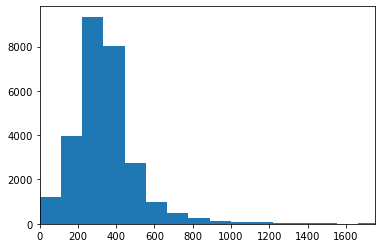

In [74]:
plt.hist(pages_data['pages'].astype(int), bins=100)
plt.xlim(0, 1750)
plt.show()

In [75]:
def categorize_pages(row):
    if int(row.pages) <= 50:
        return 'a50 or less'
    elif int(row.pages) <= 200:
        return 'b50-200 pages'
    elif int(row.pages) <= 300:
        return 'c200-300 pages'
    elif int(row.pages) <= 500:
        return 'd300-500 pages'
    elif int(row.pages) <= 1000:
        return 'e500-1000 pages' 
    else:
        return 'f1000 or more'
    
pages_data['pages_cat'] = pages_data.apply(lambda row: categorize_pages(row), axis=1)
pages_data.dropna()
pages_data.head(2)

C:\Users\GuillaumeP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,parentId,pages,pages_cat
0,Young Adult,374,d300-500 pages
1,Fantasy,870,e500-1000 pages


In [76]:
counts = pages_data['pages_cat'].unique()
counts

array(['d300-500 pages', 'e500-1000 pages', 'c200-300 pages',
       'b50-200 pages', 'f1000 or more', 'a50 or less'], dtype=object)

In [77]:
pages_data = pages_data[['parentId', 'pages_cat']].groupby(['parentId', 'pages_cat']).size().reset_index()
pages_data = pages_data.rename({'parentId': 'genre', 'pages_cat': 'pages_cat', 0: 'count'}, axis=1)

In [78]:
pages_data = pages_data.sort_values(['pages_cat', 'genre'], ascending = [True, False])

In [79]:
pages_data.head(13)

,genre,pages_cat,count
64,Young Adult,a50 or less,28
59,X and Erotica,a50 or less,21
53,Science Fiction,a50 or less,22
47,Romance,a50 or less,44
41,Poetry,a50 or less,36
35,Philosophy,a50 or less,8
29,Mystery,a50 or less,48
18,Horror,a50 or less,27
12,Fiction,a50 or less,67
6,Fantasy,a50 or less,90


In [80]:
pages_data.to_csv(path_or_buf='./website/data/biparite_pages.csv', index=False)

### Create dataset for bipartite prices

In [81]:
price_data = biparite_data[['parentId', 'price']]
price_data.head(2)

,parentId,price
0,Young Adult,5.09
1,Fantasy,7.38


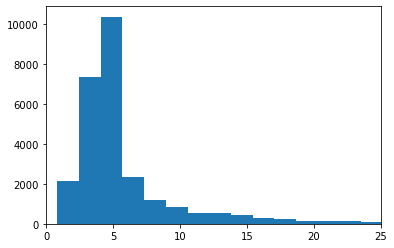

In [82]:
plt.hist(price_data['price'].astype(float), bins=500)
plt.xlim(0, 25)
plt.show()

In [83]:
def categorize_price(row):
    if float(row.price) <= 1.0:
        return 'a1$ or less'
    elif float(row.price) <= 3.0:
        return 'b1-3$'
    elif float(row.price) <= 5.0:
        return 'c3-5$'
    elif float(row.price) <= 10.0:
        return 'd5-10$'
    elif float(row.price) <= 20.0:
        return 'e10-20$' 
    else:
        return 'f20$ or more'
    
price_data['price_cat'] = price_data.apply(lambda row: categorize_price(row), axis=1)

C:\Users\GuillaumeP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [84]:
price_data.head()

,parentId,price,price_cat
0,Young Adult,5.09,d5-10$
1,Fantasy,7.38,d5-10$
2,Classics,5.09,d5-10$
3,Classics,5.09,d5-10$
4,Young Adult,2.1,b1-3$


In [85]:
counts = price_data['price_cat'].unique()
counts

array(['d5-10$', 'b1-3$', 'c3-5$', 'f20$ or more', 'a1$ or less',
       'e10-20$'], dtype=object)

Note there are books below 1.5 stars.

In [86]:
price_data = price_data[['parentId', 'price_cat']].groupby(['parentId', 'price_cat']).size().reset_index()
price_data = price_data.rename({'parentId': 'genre', 'price_cat': 'price_cat', 0: 'count'}, axis=1)

In [87]:
price_data = price_data.sort_values(['price_cat', 'genre'], ascending = [True, False])

In [88]:
price_data.head(13)

,genre,price_cat,count
65,Young Adult,a1$ or less,57
54,Science Fiction,a1$ or less,5
48,Romance,a1$ or less,53
42,Poetry,a1$ or less,6
36,Philosophy,a1$ or less,2
30,Mystery,a1$ or less,22
24,Manga,a1$ or less,11
18,Horror,a1$ or less,14
12,Fiction,a1$ or less,97
6,Fantasy,a1$ or less,57


In [89]:
price_data.to_csv(path_or_buf='./website/data/biparite_price.csv', index=False)

### Create dataset for bipartite title_length

In [90]:
title_data = biparite_data[['parentId', 'title']]
title_data['title_length']  = title_data['title'].str.len()
title_data.drop('title', axis=1, inplace=True)
title_data.head(2)

C:\Users\GuillaumeP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\GuillaumeP\Anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,parentId,title_length
0,Young Adult,16
1,Fantasy,41


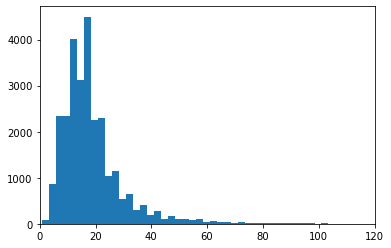

In [91]:
plt.hist(title_data['title_length'].astype(int), bins=100)
plt.xlim(0, 120)
plt.show()

In [92]:
def categorize_title(row):
    if int(row.title_length) <= 5:
        return 'a5 or less'
    elif int(row.title_length) <= 10:
        return 'b5-10 charac'
    elif int(row.title_length) <= 15:
        return 'c10-15 charac'
    elif int(row.title_length) <= 25:
        return 'd15-25 charac'
    elif int(row.title_length) <= 50:
        return 'e25-50 charac'
    else:
        return 'f50 or more'
    
title_data['title_cat'] = title_data.apply(lambda row: categorize_title(row), axis=1)
title_data.dropna()
title_data.head(2)

C:\Users\GuillaumeP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,parentId,title_length,title_cat
0,Young Adult,16,d15-25 charac
1,Fantasy,41,e25-50 charac


In [93]:
counts = title_data['title_cat'].unique()
counts

array(['d15-25 charac', 'e25-50 charac', 'b5-10 charac', 'c10-15 charac',
       'f50 or more', 'a5 or less'], dtype=object)

In [94]:
title_data = title_data[['parentId', 'title_cat']].groupby(['parentId', 'title_cat']).size().reset_index()
title_data = title_data.rename({'parentId': 'genre', 'title_cat': 'title_cat', 0: 'count'}, axis=1)

In [95]:
title_data = title_data.sort_values(['title_cat', 'genre'], ascending = [True, False])

In [96]:
title_data.head(13)

,genre,title_cat,count
66,Young Adult,a5 or less,186
60,X and Erotica,a5 or less,23
54,Science Fiction,a5 or less,61
48,Romance,a5 or less,161
42,Poetry,a5 or less,15
36,Philosophy,a5 or less,1
30,Mystery,a5 or less,35
24,Manga,a5 or less,6
18,Horror,a5 or less,90
12,Fiction,a5 or less,234


In [97]:
title_data.to_csv(path_or_buf='./website/data/biparite_titles.csv', index=False)